In [2]:
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pyspark.sql.types import IntegerType
from pyspark.sql import Row
from pyspark.sql.functions import col, mean


INPUT_PATH = "hdfs://BigDataHA/user/s277309/recsys_data/"
TEST = False

features = [
    # Tweet features
    "text_tokens",      # List[long]    Ordered list of Bert ids corresponding to Bert tokenization of Tweet text
    "hashtags",         # List[string]  Tab separated list of hastags (identifiers) present in the tweet
    "tweet_id",         # String        Tweet identifier (unique)
    "present_media",    # List[String]  Tab separated list of media types. Media type can be in (Photo, Video, Gif)
    "present_links",    # List[string]  Tab separated list of links (identifiers) included in the Tweet
    "present_domains",  # List[string]  Tab separated list of domains included in the Tweet (twitter.com, dogs.com)
    "tweet_type",       # String        Tweet type, can be either Retweet, Quote, Reply, or Toplevel
    "language",         # String        Identifier corresponding to the inferred language of the Tweet
    "tweet_timestamp",  # Long          Unix timestamp, in sec of the creation time of the Tweet
    
    # Engaged-with User (i.e., Engagee) Features
    "engaged_with_user_id",                 # String    User identifier
    "engaged_with_user_follower_count",     # Long      Number of followers of the user
    "engaged_with_user_following_count",    # Long      Number of accounts the user is following
    "engaged_with_user_is_verified",        # Bool      Is the account verified?
    "engaged_with_user_account_creation",   # Long      Unix timestamp, in seconds, of the creation time of the account
    
    # Engaging User (i.e., Engager) Features
    "engaging_user_id",                     # String    User identifier   
    "engaging_user_follower_count",         # Long      Number of followers of the user
    "engaging_user_following_count",        # Long      Number of accounts the user is following
    "engaging_user_is_verified",            # Bool      Is the account verified?
    "engaging_user_account_creation",       # Long      Unix timestamp, in seconds, of the creation time of the account
    
    # Engagement features
    "engagee_follows_engager"   # Bool  Engagee follows engager?
]

features_idx = dict(zip(features, range(len(features))))

labels_idx = {
    # Engagement features (cont.)
    "reply_timestamp": 20,                  # Long      Unix timestamp (in seconds) of one of the replies, if there is at least one
    "retweet_timestamp": 21,                # Long      Unix timestamp (in seconds) of the retweet by the engaging user, if there is at least one
    "retweet_with_comment_timestamp": 22,   # Long      Unix timestamp (in seconds) of one of the retweet with comment by the engaging user, if there is at least one
    "like_timestamp": 23                    # Long      Unix timestamp (in seconds) of the like by the engaging user, if they liked the tweet
}

labels = list(labels_idx.keys())


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Dataset

In [3]:
if TEST:
    INPUT_PATH = "recsys_data_sample_generated/sample_0.0000"
    df = spark.read.parquet(INPUT_PATH)
else:
    schema = features + list(labels)  # Column names
    df = sc.textFile(INPUT_PATH).map(lambda line: line.strip().split("\x01")).toDF(schema)

In [4]:
def binarize_label(el):
    if el != '':
        return 1
    return 0

binarize = spark.udf.register("binary", binarize_label, IntegerType())

# Documentation suggests not to use withColumn in a for loop.
# But it is not clear how to add multiple columns with a single call
binary_labels = []
for l in labels:
    bin_l = "binary_" + l
    df = df.withColumn(bin_l, binarize(df[l]))
    binary_labels.append(bin_l)

# Helper functions

In [5]:
def hour_of_day(raw_data, features = None):
    """
    Extract hour of day (numerical) from tweet_timestamp. UTC time zone
    """
    hod = spark.udf.register("HourOfDay", lambda col_value: time.strftime("%H", time.localtime(int(col_value))))
    raw_data = raw_data.withColumn("hour_of_day", hod(raw_data["tweet_timestamp"]))

    return raw_data


def day_of_week(raw_data, features = None):
    """
    Extract day of the week (categorical) from tweet_timestamp. UTC time zone

    NOTE: koalas has implemented function to return weekday as number. I guess this suggests wrong ordering,
          being Sunday closer to Monday than Friday. Verify effect on model's predictions
    """
    dow = spark.udf.register("DayOfWeek", lambda col_value: time.strftime("%A", time.localtime(int(col_value))))
    raw_data = raw_data.withColumn("day_of_week", dow(raw_data["tweet_timestamp"]))
    return raw_data


def word_count(raw_data, features = None):
    """
    Count number of words in "text_tokens" field of raw data
    """
    # TODO(test) try stopwords removal (maybe expensive and ineffective)
    wc = spark.udf.register("WordCount", lambda col_value: len(col_value.split("\t")))
    raw_data = raw_data.withColumn("word_count", wc(raw_data["text_tokens"]))
    return raw_data

# EDA
Compute conditioned probability of a label being equal to 1, conditioning on one or more attributes.

In [6]:
def conditional_prob(df, conditioning_rv, target, alpha, extractors = list()):
    """
    Estimate and plot conditional probability of a target being True, given a set of conditioning random variables.
    This function is not suitable if we have attributes of type List[string], e.g. hashtags.
    
    Args:
        df (DataFrame): pyspark DataFrame with random variables sample realizations
        conditioning_rv (List[str]): names of the conditioning random_variables
        target: target random variable for which parameter is being estimated
        alpha (float): smoothing coefficient
        extractors (list(fucntions)): function to extract custm features. Name of the feature = name of the function.
    Return:
        result: dataframe column with conditioned probability value for each sample
    """
    
    # For fields like hashtags, of type List[str] -> unwind the list and create a record for each value in the list
    def unwindField(row, field_name):
        dict_row = row.asDict()
        field = dict_row.pop(field_name, None)
        
        rows = []
        if field: # If not empty
            for el in field.split('\t'):
                dict_row[field_name] = el
                rows.append(Row(**dict_row))

        else:
            dict_row[field_name] = 'None' # Instead of str('')
            rows.append(Row(**dict_row))

        return rows
    
    targets_dict = {
        'binary_reply_timestamp': 'reply',
        'binary_retweet_timestamp': 'retweet',
        'binary_retweet_with_comment_timestamp': 'retweet_comment',
        'binary_like_timestamp': 'like'
    }
    
    # Precomputed targets average
    mean_dict = {
        'binary_reply_timestamp': 0.029,
        'binary_retweet_timestamp': 0.088,
        'binary_retweet_with_comment_timestamp': 0.007,
        'binary_like_timestamp': 0.397
    }
    
    # Get a readable target name
    target_name = targets_dict[target]
    
    # get target mean for smoothing
    target_mean = mean_dict[target]
    
    
    ############ PREPROCESS ############
    for field in conditioning_rv:
        if field in ["text_tokens", "hashtags", "present_media", "present_links", "present_domains"]:
            df = df.rdd.flatMap(lambda row: unwindField(row, field)).toDF()
            
            
    ############ FEATURE EXTRACTION ############
    for function in extractors:
        df = function(df)
        conditioning_rv.append(function.__name__)
            
    
    ############ ENCODING ############
    target_encoded = df.groupBy(conditioning_rv).\
        agg({f"{target}":"mean", "*":"count"}).\
        withColumnRenamed(f"avg({target})", f"avg_{target_name}").\
        withColumnRenamed("count(1)", "num_samples")
    
    # Computed the smoothed mean: (n*x_avg + alpha*target_avg) / (n + alpha)
    target_encoded = target_encoded.withColumn(f"smoothed_avg_{target_name}",
                              (col("num_samples")*col(f"avg_{target_name}") + (alpha*target_mean)) / \
                              (col("num_samples") + alpha))
    
    
    ############ PLOTS ############
    fig, axes = plt.subplots(1, 2, figsize=(17, 5))
    
    # Without smoothing
    plotDF = target_encoded.groupBy('avg_{}'.format(target_name)).\
        agg({'num_samples': 'sum'}).\
        withColumnRenamed("sum(num_samples)", "num_samples")
    pdDF = plotDF.select(f"avg_{target_name}", "num_samples").toPandas().sort_values(f"avg_{target_name}") # Memory issues?
    axes[0].plot(pdDF[f"avg_{target_name}"],
                pdDF["num_samples"], marker = 'o')
    
    # With smoothing
    plotDF = target_encoded.groupBy('smoothed_avg_{}'.format(target_name)).\
        agg({'num_samples': 'sum'}).\
        withColumnRenamed("sum(num_samples)", "num_samples")
    pdDF = plotDF.select(f"smoothed_avg_{target_name}", "num_samples").toPandas().sort_values(f"smoothed_avg_{target_name}") # Memory issues?
    axes[1].plot(pdDF[f"smoothed_avg_{target_name}"],
                pdDF["num_samples"], marker = 'o')
    
    for i in range(len(axes)):
        axes[i].set_ylim(bottom=0)
        axes[i].set_xlim(left = 0)
        axes[i].set_ylabel("Samples per mean target value")
    
    axes[0].set_xlabel("Mean target values")
    axes[0].set_title(target_name + ' conditioned on [' + ', '.join(conditioning_rv) + ']')
    
    axes[1].set_xlabel("Smoothed mean target values")
    axes[1].set_title(target_name + ' conditioned on [' + ', '.join(conditioning_rv) + ']' + " - smoothed")
    
    plt.show()
    
    # Other plots?
                                                                                        
    return target_encoded

In [7]:
# Smoothing factor
ALPHA = 20

## Example use: toy dataset

In [5]:
toy_df = df.limit(1000)

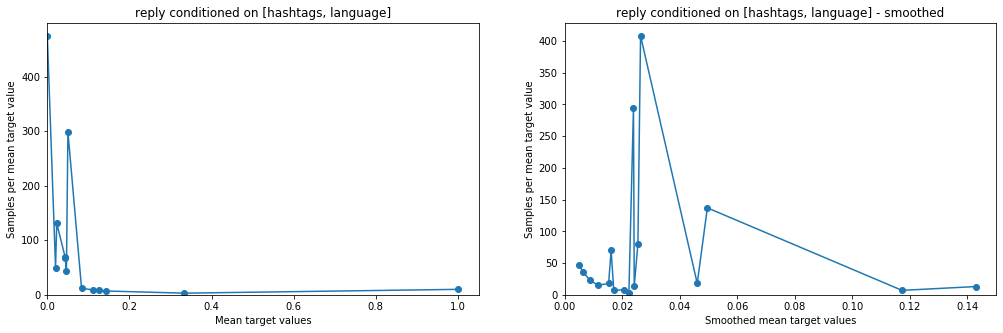

In [10]:
# Better to have a single random variable to test significance
# To group on more than one field, simply reapply this function
result = conditional_prob(toy_df, ["hashtags", "language"], "binary_reply_timestamp", ALPHA)

## Dataset EDA

In order for conditioning (and target encoding) to be meaningful, we would like to see sparsity of conditional probabilities estimates (e.g. see hashtags estimates: that is an example of not meaningful target encoding).

### Hashtags

Result is meaningless for 'hashtags' alone: on average we have ~0.4 probability, which is very close to the probability of having 'like' = 1 unconditioned.  
NOTE: Do we have to maintain None values?

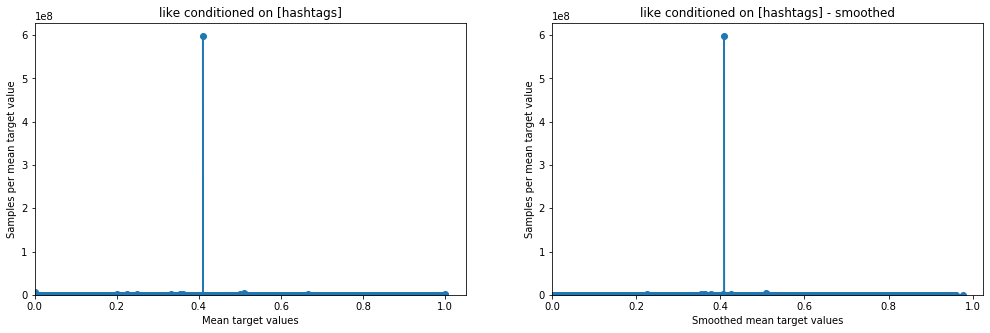

CPU times: user 2.1 s, sys: 546 ms, total: 2.65 s
Wall time: 5min 48s


In [15]:
%%time
result = conditional_prob(df, ["hashtags"], "binary_like_timestamp", ALPHA)

### Hashtags, Language

Results may become meaningful if we condition on more than one field: we condition together over ashtags and language, being likely that hashtags in a tweet are mainly associated to a particular language

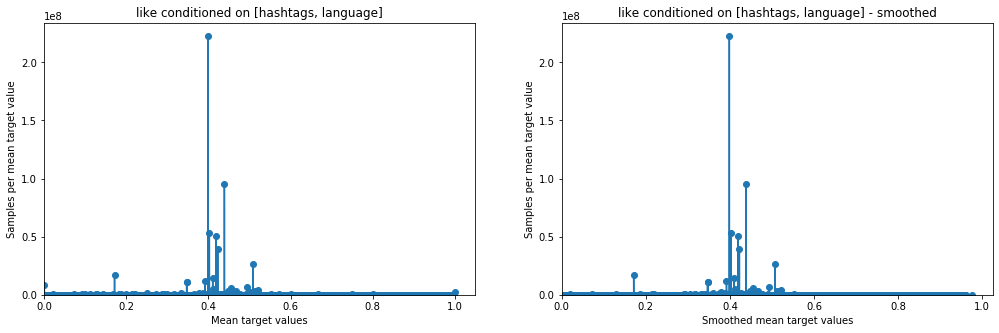

CPU times: user 2.27 s, sys: 520 ms, total: 2.79 s
Wall time: 6min 31s


In [12]:
%%time
result = conditional_prob(df, ["hashtags", "language"], "binary_like_timestamp", ALPHA)

## engaging_user_id

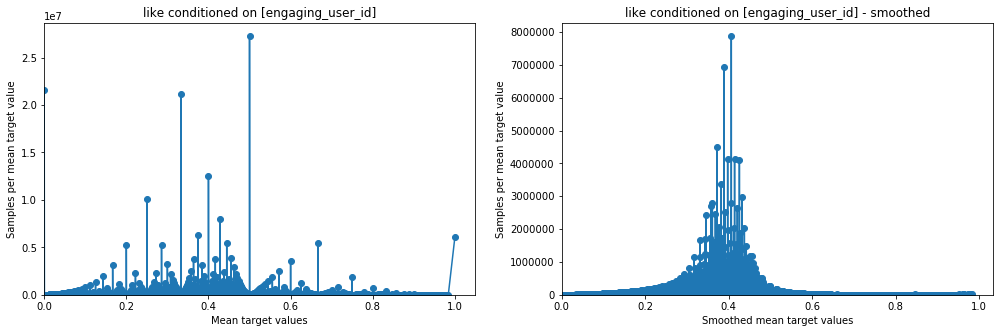

CPU times: user 2.68 s, sys: 492 ms, total: 3.17 s
Wall time: 2min 7s


In [9]:
%%time
# Super good
result = conditional_prob(df, ["engaging_user_id"], "binary_like_timestamp", ALPHA)

## engaging_user_id, language

Note the high number of 1 occurrences: this is likely due to hashtags encountered only once, for which 'like' was either 0 or 1. We need to account for this -> NVIDIA rapidsAI introduced a smoothing coefficient (see https://youtu.be/d-HXUadCUhA?t=11770).

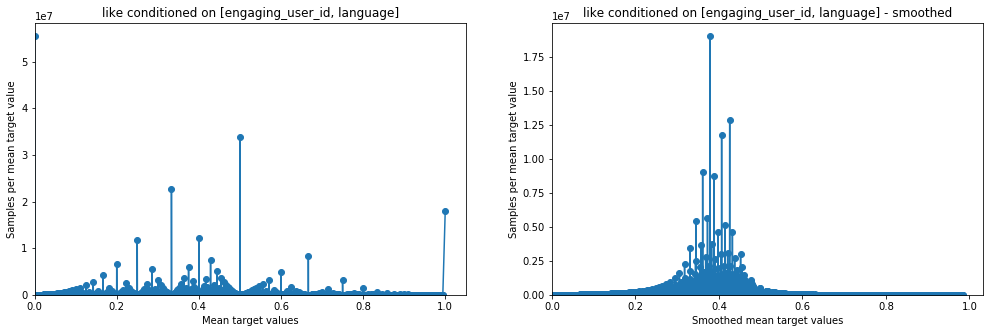

CPU times: user 2.51 s, sys: 538 ms, total: 3.05 s
Wall time: 2min 4s


In [13]:
%%time
# Super good
result = conditional_prob(df, ["engaging_user_id", "language"], "binary_like_timestamp", ALPHA)

### hour_of_day, language

This feature can be useful to account for time zones: hour_of_day per se is meaningless, since it is not uniform for all users. Instead, it becomes more meaningful if correlated with language, where language is a proxy for the gographical location. Note, this assumption is true if English US is cosidered as different language from English UK and AU, which is likely to be true, but the hypothesis should be validated.

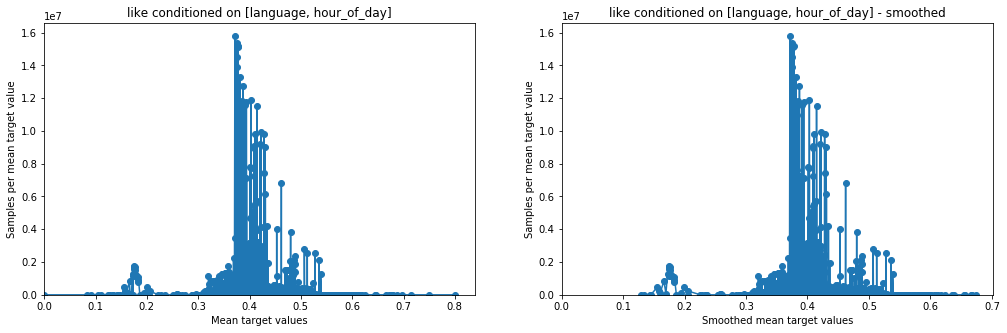

In [14]:
# Usato, good
result = conditional_prob(df, ["language"], "binary_like_timestamp", ALPHA, [hour_of_day])

## Language

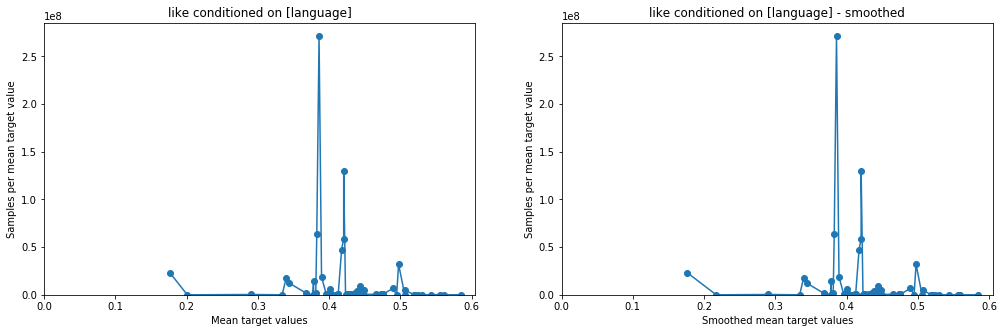

In [8]:
# Messo da andrea (Count invece che target encoding)
result = conditional_prob(df, ["language"], "binary_like_timestamp", ALPHA)

## Tweet Type

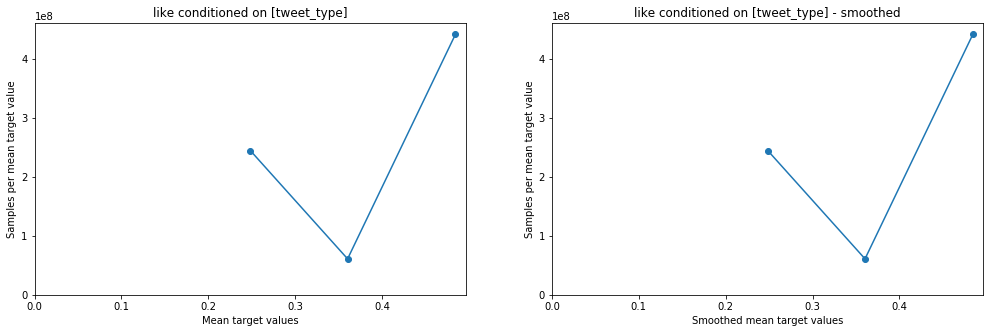

In [9]:
# Messo da andrea
result = conditional_prob(df, ["tweet_type"], "binary_like_timestamp", ALPHA)

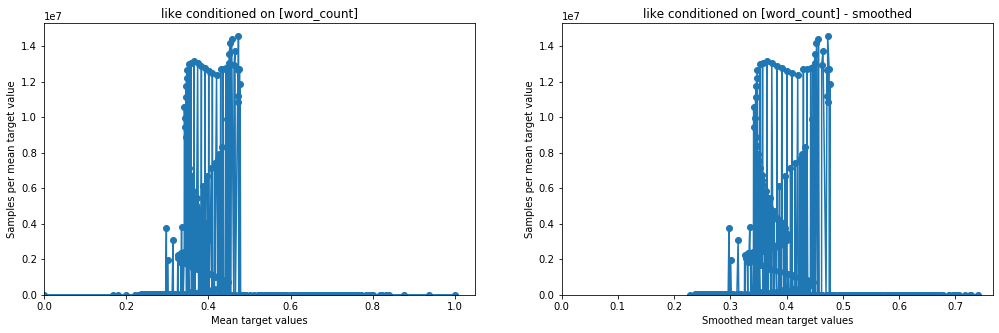

In [10]:
result = conditional_prob(df, [], "binary_like_timestamp", ALPHA, [word_count])

## Word count - tweet type

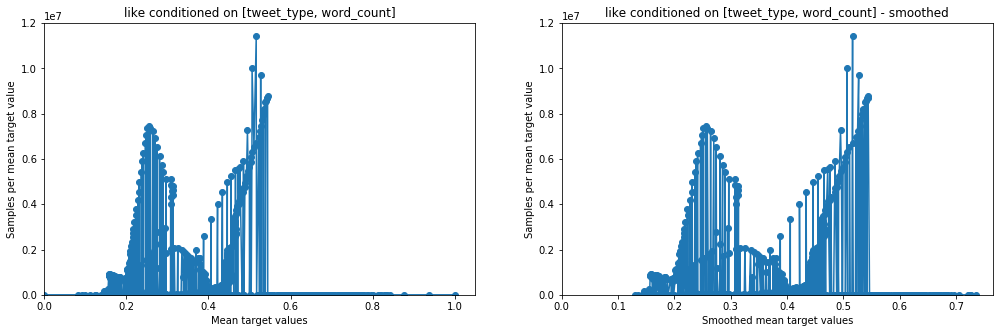

In [14]:
result = conditional_prob(df, ["tweet_type"], "binary_like_timestamp", ALPHA, [word_count])

## Day of week - engaging user id

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


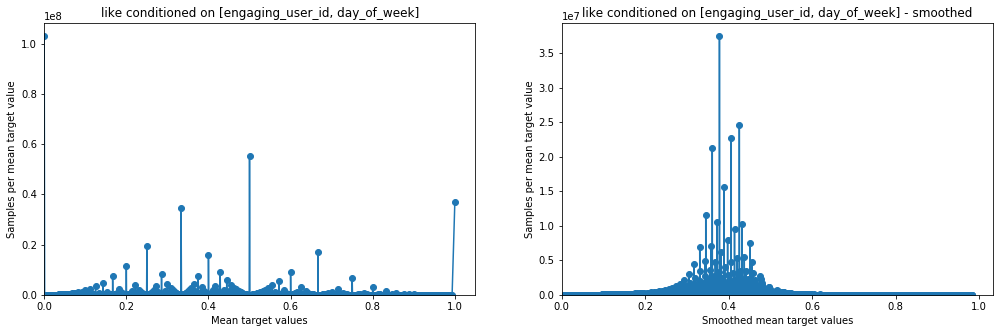

In [8]:
result = conditional_prob(df, ["engaging_user_id"], "binary_like_timestamp", ALPHA, [day_of_week])

## Hour of day - engaging user id

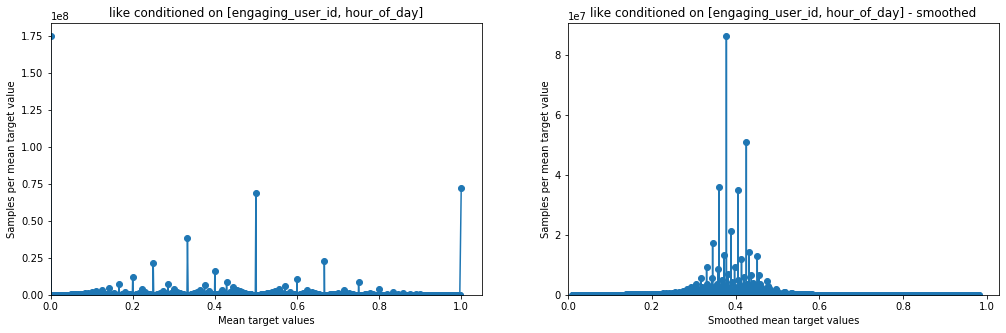

In [18]:
# Sulla falsa riga di language, quindi è dominato da engaging user
# Bisogna vedere quale da i migliori risultati
result = conditional_prob(df, ["engaging_user_id"], "binary_like_timestamp", ALPHA, [hour_of_day])